In [16]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from six import StringIO
from IPython.display import Image
import pydotplus
import seaborn as sb
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import GridSearchCV, train_test_split

import warnings
warnings.filterwarnings("ignore")

In [17]:
class_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_2.csv")
class_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_2.csv")
regression_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_3.csv")
regression_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_3.csv")

## Предварительная обработка данных
Произведём пред обработку данных для задачи классификации

In [18]:
class_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
class_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
class_all = class_num + class_cat
class_result = "Response"
class_train.drop("id", axis=1, inplace=True)
class_test.drop("id", axis=1, inplace=True)
# Кодирование категориальных признаков
le = LabelEncoder()
for column in class_cat:
    class_train[column] = le.fit_transform(class_train[column])
    class_test[column] = le.fit_transform(class_test[column])
    class_train[column] = class_train[column].astype("category")
    class_test[column] = class_test[column].astype("category")
# Нормализация числовых признаков
scaler = MinMaxScaler()
class_train[class_num] = scaler.fit_transform(class_train[class_num])
class_test[class_num] = scaler.fit_transform(class_test[class_num])
class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                229292 non-null  category
 1   Age                   229292 non-null  float64 
 2   Driving_License       229292 non-null  float64 
 3   Region_Code           229292 non-null  float64 
 4   Previously_Insured    229292 non-null  float64 
 5   Vehicle_Age           229292 non-null  category
 6   Vehicle_Damage        229292 non-null  category
 7   Annual_Premium        229292 non-null  float64 
 8   Policy_Sales_Channel  229292 non-null  float64 
 9   Vintage               229292 non-null  float64 
 10  Response              229292 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 14.7 MB


Отбросим часть тренировочной выборки

In [19]:
number_of_elements = 20000  # Количество элементов
class_train = class_train.sample(n=number_of_elements, replace=False)
class_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 19861 to 45251
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                20000 non-null  category
 1   Age                   20000 non-null  float64 
 2   Driving_License       20000 non-null  float64 
 3   Region_Code           20000 non-null  float64 
 4   Previously_Insured    20000 non-null  float64 
 5   Vehicle_Age           20000 non-null  category
 6   Vehicle_Damage        20000 non-null  category
 7   Annual_Premium        20000 non-null  float64 
 8   Policy_Sales_Channel  20000 non-null  float64 
 9   Vintage               20000 non-null  float64 
 10  Response              20000 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


Произведём пред обработку данных для задачи регрессии

In [20]:
regression_result = 'Цена'
regression_train.drop("id", axis=1, inplace=True)
regression_test.drop("id", axis=1, inplace=True)
# Удаляем некоторые категориальные признаки для избежания ловушки фиктивных переменных
regression_train.drop("Без.ремонта", axis=1, inplace=True)
regression_train.drop("Совмещенный.санузел", axis=1, inplace=True)
regression_train.drop("Смешанные.стены", axis=1, inplace=True)
regression_train.drop("Иные.перекрытия", axis=1, inplace=True)
# Разделение на числовые и категориальные
regression_num = []
regression_cat = []
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:
        regression_num.append(name)
    else:
        regression_cat.append(name)
regression_num.remove(regression_result)
regression_all = regression_num + regression_cat
# Нормализация числовых признаков
scaler = MinMaxScaler()
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Раздельный.санузел         808 non-null    int64  
 12  Лифт                       808 non-null    int64  
 13  Грузовой.лифт              808 non-null    int64  

## Отбор информативных признаков

In [21]:
x = class_train[class_all]
y = class_train[class_result]
sfs = SequentialFeatureSelector(GaussianNB(), n_features_to_select=5, n_jobs=-1, scoring="roc_auc")
values = sfs.fit(x, y)
selected_features = values.get_feature_names_out()
class_train = class_train.loc[:, np.append(selected_features, class_result)]
class_test = class_test.loc[:, selected_features]
class_all = selected_features
x = class_train[class_all]
y = class_train[class_result]
class_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 19861 to 45251
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 20000 non-null  float64 
 1   Previously_Insured  20000 non-null  float64 
 2   Region_Code         20000 non-null  float64 
 3   Annual_Premium      20000 non-null  float64 
 4   Vehicle_Damage      20000 non-null  category
 5   Response            20000 non-null  int64   
dtypes: category(1), float64(4), int64(1)
memory usage: 957.2 KB


Произведём сэмплирование данных для задачи классификации

In [22]:
def build_response_graph(column):
    plt.pie(column.value_counts(), labels=(0, 1))
    plt.title("Распределение значения response в выборке")
    plt.legend((0, 1))
    plt.show()

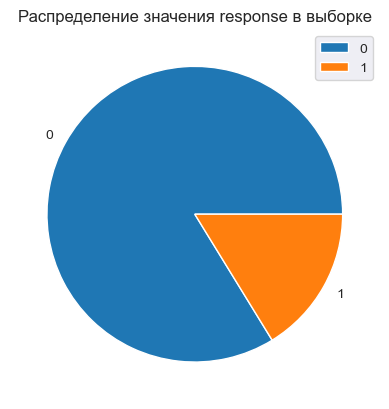

In [23]:
build_response_graph(class_train[class_result])

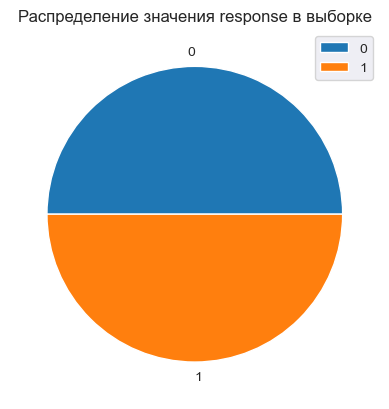

In [24]:
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)
build_response_graph(y)

Разобьём выборки на train и test

In [25]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size=0.3, random_state=7)
x = regression_train[regression_all]
y = regression_train[regression_result]
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение деревьев решений

In [26]:
def create_train_model(clf, x_train, y_train, x_test, y_test) -> GridSearchCV:
    param_grid={}
    print("Started creation")
    """Создать и обучить модель с подбором параметров."""
    new_model = GridSearchCV(clf, param_grid, n_jobs=-1, scoring="roc_auc").fit(x_train, y_train)
    if param_grid:
        print(new_model.best_estimator_)
    print("Score (ROC_AUC): " + str(round(new_model.score(x_test, y_test), 3)))
    return new_model

In [27]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)
dt = dt.fit(x_train_c, y_train_c)

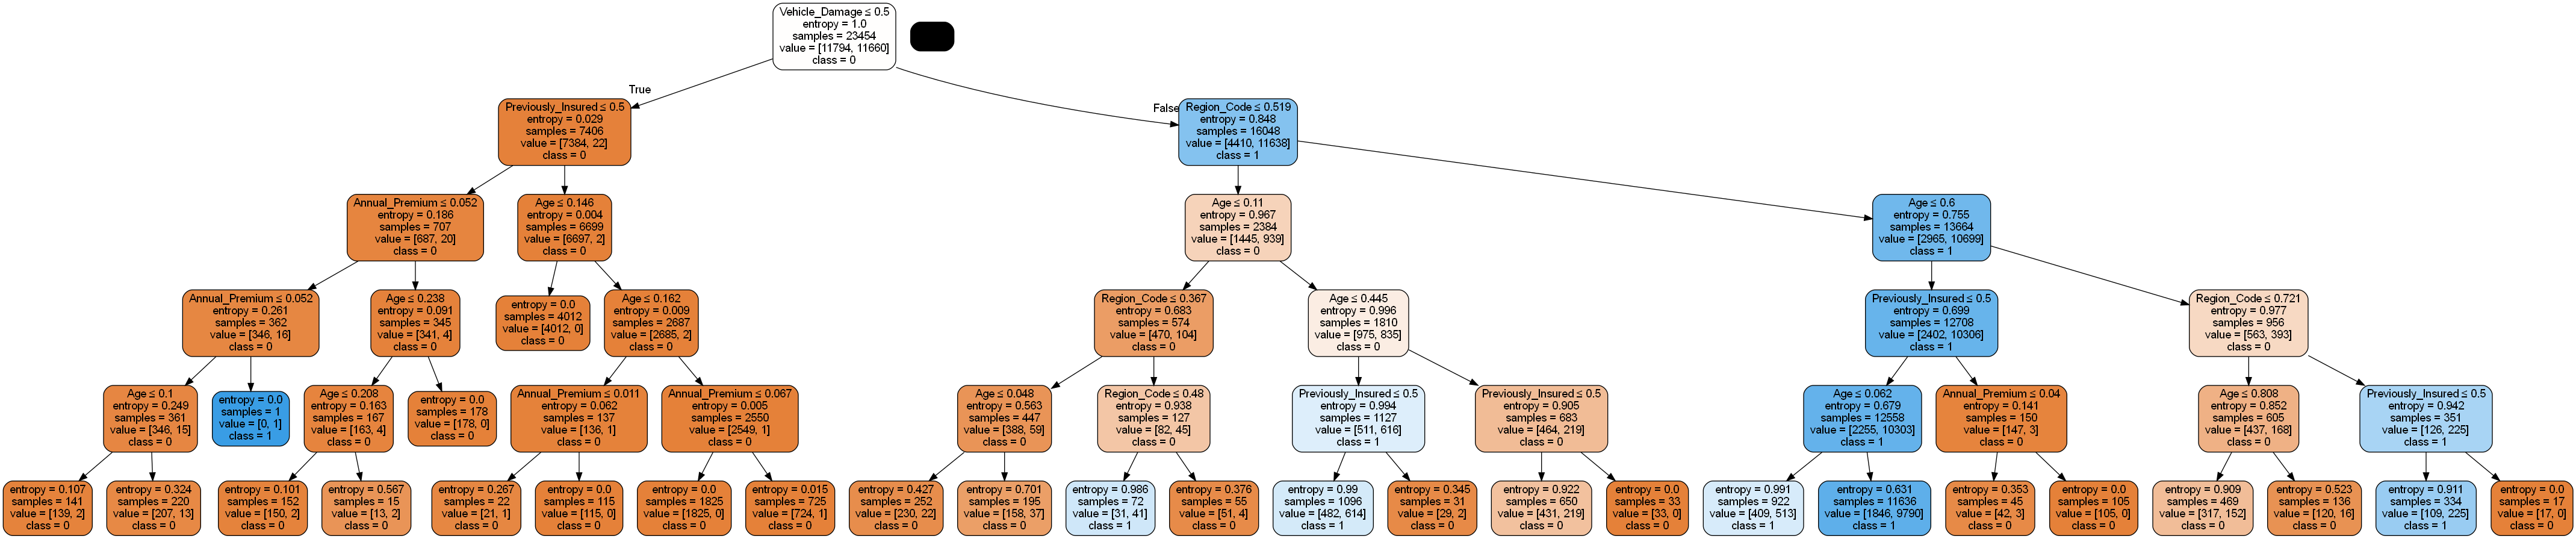

In [28]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True,
                special_characters=True, feature_names=class_all, class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('new.png')
Image(graph.create_png())